Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Importing and mouting google drive and setting Train and Test paths
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
train_path="drive/My Drive/Skin_Cancer_Images/Train"
test_path="drive/My Drive/Skin_Cancer_Images/Test"

Mounted at /content/drive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
print(data_dir_train,data_dir_test)

drive/My Drive/Skin_Cancer_Images/Train drive/My Drive/Skin_Cancer_Images/Test


In [ ]:
# Globbing all jpg images to confirm the training and test dataset size. Looks like we have small dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
     

2239
118


In [5]:
# Let us define some parameters , we have been asked to resize images to 180 X 180

batch_size = 32
img_height = 180
img_width = 180

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
reverse_class_indices = {}
print(type(class_names))

for i,cname in enumerate(class_names):
  reverse_class_indices[i] = cname
     

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
<class 'list'>


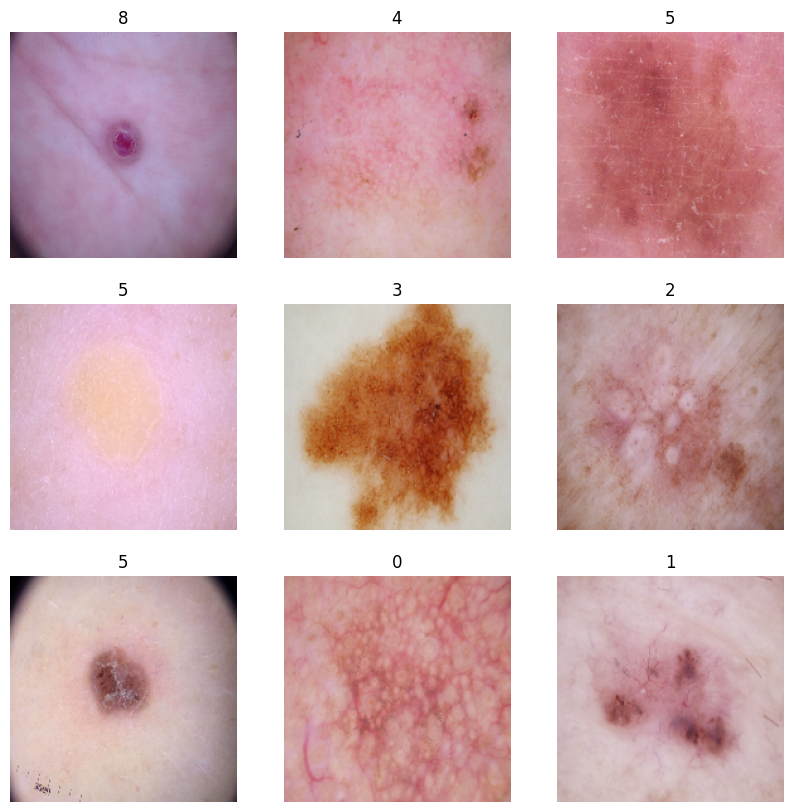

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# Sample inspection of images , we choose 1 random sample from each class and also provide their numerical labels.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Base model with CNN and Pooling layers, without any augmentation. Rescaling is not used yet.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

NUM_CLASSES = 9

def create_model_base():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(180, 180, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()


epochs = 20

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = 'drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

model = create_model_base()
model.fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks=[checkpoint, history] ) 


model.save("drive/My Drive/Skin_Cancer_Images/ccn_model_1.h5")

Epoch 1/20
70/70 [==============================] - 5s 60ms/step - loss: 10.2334 - accuracy: 0.1916 - val_loss: 2.1863 - val_accuracy: 0.1441
Epoch 2/20
70/70 [==============================] - 4s 54ms/step - loss: 2.1398 - accuracy: 0.2010 - val_loss: 2.1805 - val_accuracy: 0.1271
Epoch 3/20
70/70 [==============================] - 4s 52ms/step - loss: 2.0999 - accuracy: 0.1956 - val_loss: 2.1855 - val_accuracy: 0.1271
Epoch 4/20
70/70 [==============================] - 4s 52ms/step - loss: 2.0687 - accuracy: 0.1956 - val_loss: 2.1994 - val_accuracy: 0.1271
Epoch 5/20
70/70 [==============================] - 4s 55ms/step - loss: 2.0478 - accuracy: 0.1956 - val_loss: 2.2167 - val_accuracy: 0.1271
Epoch 6/20
70/70 [==============================] - 4s 53ms/step - loss: 2.0340 - accuracy: 0.1961 - val_loss: 2.2284 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 4s 53ms/step - loss: 2.0259 - accuracy: 0.1996 - val_loss: 2.2437 - val_accuracy: 0.1441
Epoch 8/20
7

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 84, 84, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 128)       204928    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 19, 128)     

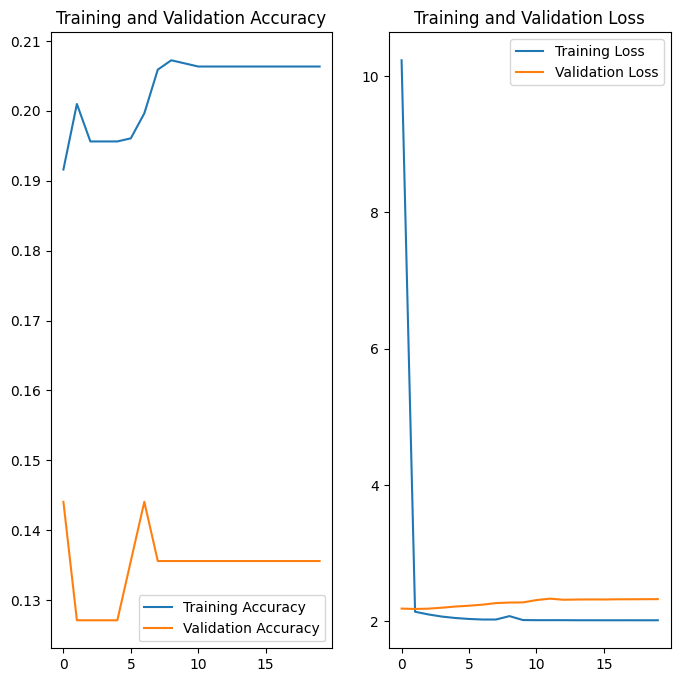

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Conclusion :  Training Loss and validation loss are almost similar. The accuracies are also hovering between 15-20% . That means, model is neither overfit not underfit. It has not learned the data that well due to smaller data size and likely learning rate can be adjusted further. Dropouts are already included in the model here.

Let us try augmentation technique next. We will use rescaling so that all pixel values are within 0 and 1. We can horizontally or vertically flip the images. There is no point in using shift and contrasting/brightness augmentation since location of the cancer patch is not important and contrasting / brightness will actually lead to loss of critical data. We will also add rotation and zooming as strategy so that we get variations required.

In [ ]:

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomZoom(0.5),
])

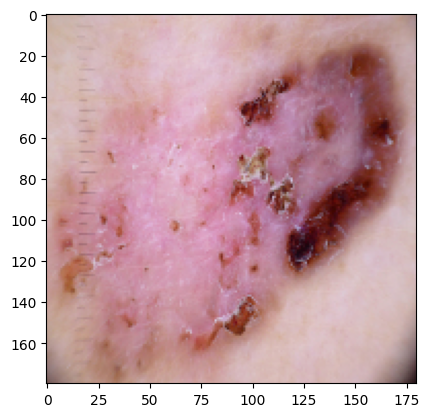

In [ ]:

# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Let us inspect one image to confirm original images and its associated augmented image.
image, label = next(iter(train_ds))
im = image[0]
plt.imshow(im.numpy().astype("uint8"))





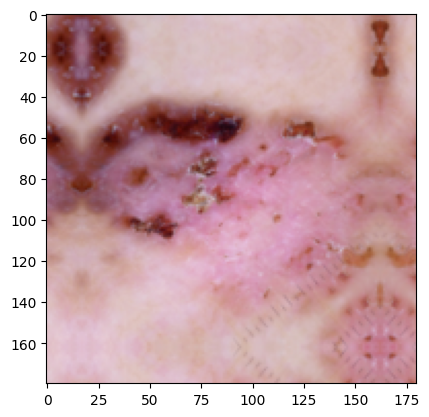

In [ ]:
augmented_image = data_augmentation(im)
plt.imshow(augmented_image)



In [ ]:
# Now let us crate augmentation dataset by applying augmentation definition above to train_ds. 
# We don't apply any other augmentation technique to validation dataset except rescaling.

aug_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
val_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
])

In [ ]:
val_aug_ds = val_ds.map( lambda x, y: (val_augmentation(x), y))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()


epochs = 20

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = 'drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_2.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

aug_model = create_model_base()
aug_model.fit(aug_ds, validation_data = val_aug_ds, epochs = epochs, callbacks=[checkpoint, history] ) 


aug_model.save("drive/My Drive/Skin_Cancer_Images/ccn_model_2.h5")

Epoch 1/20
70/70 [==============================] - 44s 354ms/step - loss: 2.0358 - accuracy: 0.2197 - val_loss: 2.2050 - val_accuracy: 0.1780
Epoch 2/20
70/70 [==============================] - 19s 272ms/step - loss: 1.9206 - accuracy: 0.2966 - val_loss: 2.1780 - val_accuracy: 0.1695
Epoch 3/20
70/70 [==============================] - 23s 333ms/step - loss: 1.7751 - accuracy: 0.3515 - val_loss: 2.1854 - val_accuracy: 0.2797
Epoch 4/20
70/70 [==============================] - 20s 284ms/step - loss: 1.5935 - accuracy: 0.4319 - val_loss: 1.9632 - val_accuracy: 0.2966
Epoch 5/20
70/70 [==============================] - 21s 297ms/step - loss: 1.5347 - accuracy: 0.4448 - val_loss: 2.0891 - val_accuracy: 0.3136
Epoch 6/20
70/70 [==============================] - 20s 284ms/step - loss: 1.4978 - accuracy: 0.4739 - val_loss: 2.4003 - val_accuracy: 0.2881
Epoch 7/20
70/70 [==============================] - 20s 291ms/step - loss: 1.5329 - accuracy: 0.4506 - val_loss: 2.2186 - val_accuracy: 0.3051

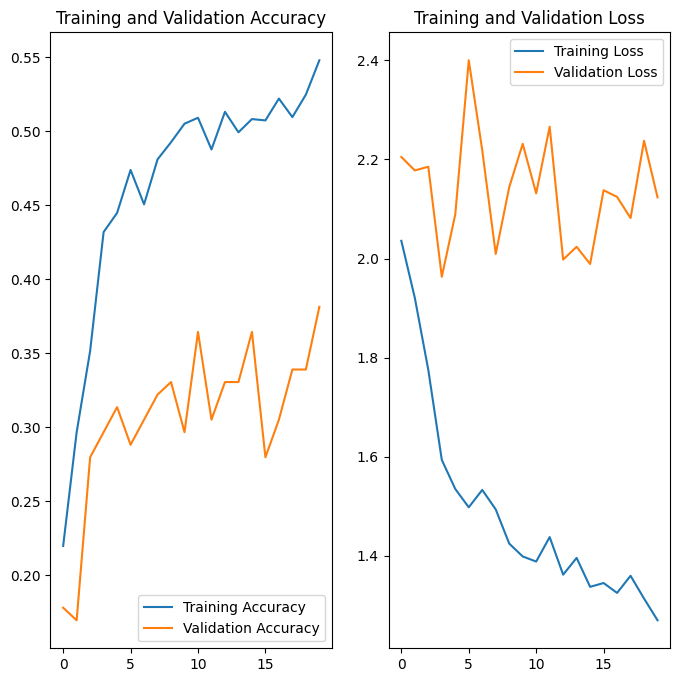

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Conclusion : After applying augmentation as part of keras preprocessing, there is some improvement in results. Model is now overfitting though . Validation loss has continued to increase or remained at one level while training loss has been reducing constantly. Accuracy has improved though for training and validation dataset which means model training and generalisation has improved.

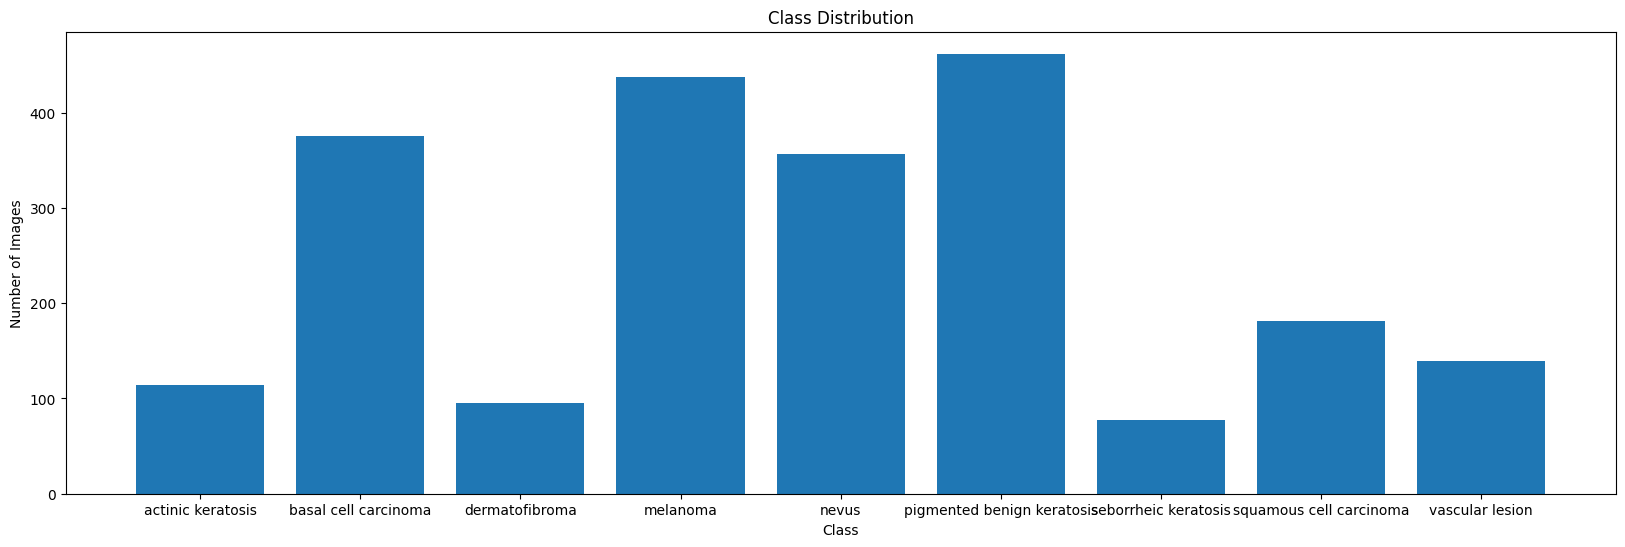

In [ ]:
# Let us inspect class imbalance

class_counts = []
for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(train_path, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)
    
classes = reverse_class_indices.values()

fig = plt.figure(figsize=(20, 6))

# Create a bar chart to visualize the class distribution
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Conclusion :  There is class imbalance here. Certainl classs like "seborrheic keratosis" are quite underrepresented. We can solve the imbalance in multiple ways like using weightage to classes or oversampling classes such that all classes are balancely represented in the training. Let us oversample upto 500 .

In [ ]:
!pip install Augmentor
path_to_training_dataset=train_path
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(train_path + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Initialised with 114 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CC4F4DD60>: 100%|██████████| 500/500 [00:23<00:00, 21.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5CC5F142B0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CC4F88790>: 100%|██████████| 500/500 [00:20<00:00, 24.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F5CC5F2D160>: 100%|██████████| 500/500 [01:37<00:00,  5.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CC5ECF5E0>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5CC5EE7D00>: 100%|██████████| 500/500 [00:20<00:00, 24.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5CC5FE95B0>: 100%|██████████| 500/500 [00:49<00:00, 10.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DE6594CD0>: 100%|██████████| 500/500 [00:20<00:00, 24.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/My Drive/Skin_Cancer_Images/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5CC5EF7E50>: 100%|██████████| 500/500 [00:22<00:00, 22.24 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
     

4500


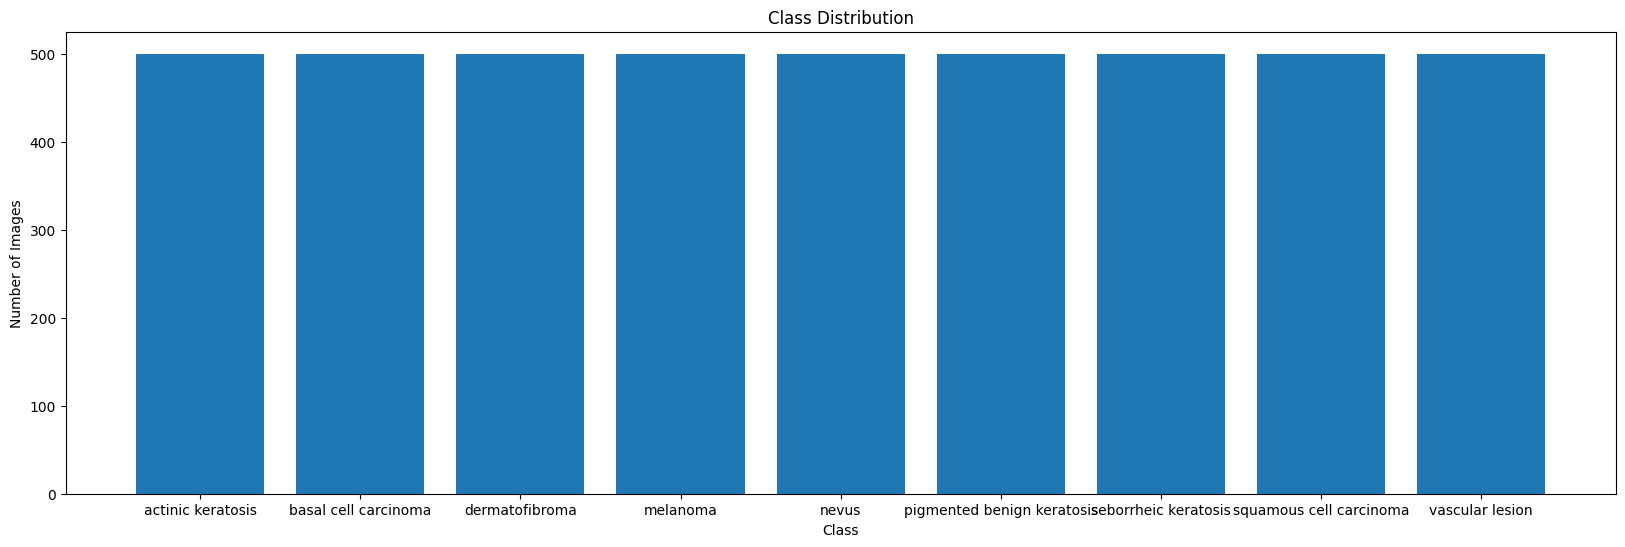

In [ ]:
# Let us inspect class imbalance now after oversampling.
NUM_CLASSES = 9
class_counts = []

for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(train_path, class_name)
    class_dir = os.path.join(class_dir, "output")
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)
    
classes = reverse_class_indices.values()

fig = plt.figure(figsize=(20, 6))

# Create a bar chart to visualize the class distribution
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
# In this section we will split the data created from Augmentor . 


# train dataset from newly oversampled and augmented data.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [12]:
# validation dataset from newly oversampled and augmented data.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)
     

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [13]:
#  Let us rescale them to 0 to 1
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
])

train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
val_augmentation = tf.keras.Sequential([
  layers.Rescaling(1./255),
])

val_aug_ds = val_ds.map( lambda x, y: (val_augmentation(x), y))


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_aug_ds = val_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
history = History()

epochs = 30

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = 'drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_3.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

new_aug_model = create_model_base()
new_aug_model.fit(train_ds, validation_data = val_aug_ds, epochs = epochs, callbacks=[checkpoint, history] ) 

new_aug_model.save("drive/My Drive/Skin_Cancer_Images/ccn_model_3.h5")

Epoch 1/30
169/169 [==============================] - 2250s 3s/step - loss: 2.2198 - accuracy: 0.1346 - val_loss: 2.1781 - val_accuracy: 0.1485
Epoch 2/30
169/169 [==============================] - 9s 56ms/step - loss: 2.1798 - accuracy: 0.1447 - val_loss: 2.1948 - val_accuracy: 0.1359
Epoch 3/30
169/169 [==============================] - 10s 61ms/step - loss: 2.1853 - accuracy: 0.1408 - val_loss: 2.1878 - val_accuracy: 0.1359
Epoch 4/30
169/169 [==============================] - 10s 59ms/step - loss: 2.1753 - accuracy: 0.1476 - val_loss: 2.1886 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 10s 59ms/step - loss: 2.2865 - accuracy: 0.1413 - val_loss: 2.1867 - val_accuracy: 0.1403
Epoch 6/30
169/169 [==============================] - 11s 64ms/step - loss: 2.1990 - accuracy: 0.1409 - val_loss: 2.1868 - val_accuracy: 0.1359
Epoch 7/30
169/169 [==============================] - 10s 58ms/step - loss: 2.2301 - accuracy: 0.1356 - val_loss: 2.1847 - val_accuracy: 

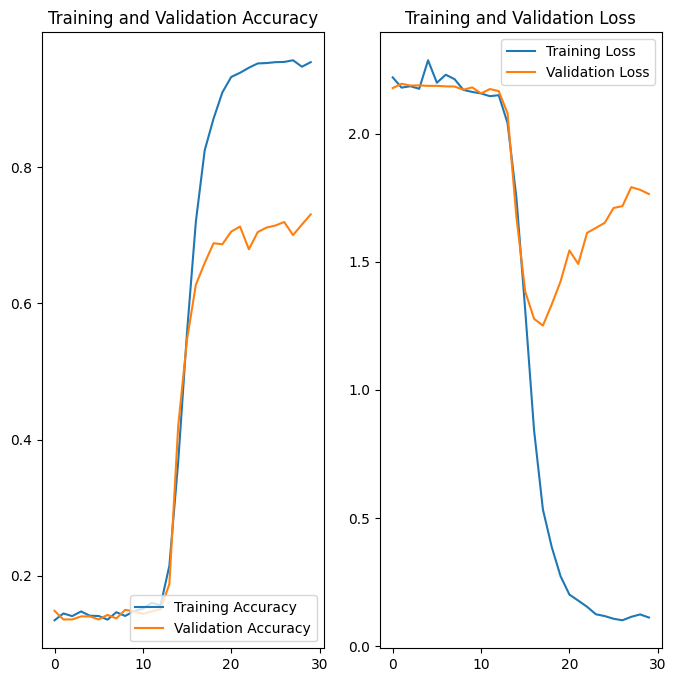

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Conclusion : This is now much more improvement in model fit. Training loss has continously gone down , validation loss has gone down till epoch 22. Accuracy similarly is much higher as compared to earlier two iterations. So I will choose the model correspondng to epoch 22 and stop training at epoch 22. I can further tune learning rate and slow down learning bit further to reduce overfitting. 